In [7]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from numpy import array
from scipy.signal import chirp
import scienceplots

np.set_printoptions(precision=3, suppress=True)

plt.style.use([
    'grid',
    'retro'
])

In [8]:
m_v = 1500
J_v = 2400
m_d = 100
m_t = 100

M = np.diag([m_v, J_v, m_d, m_t])

c_sd = 500
c_st = 500

l_d  = 1.17
l_t  = 1.68

C = array([
    [c_sd+c_st, l_d*c_sd-l_t*c_st, -c_sd, -c_st],
    [l_d*c_sd-l_t*c_st, l_d**2*c_sd+l_t**2*c_st, -l_d*c_sd, l_t*c_st],
    [-c_sd, -l_d*c_sd, c_sd, 0],
    [-c_st, l_t*c_st, 0, c_st]
])

k_sd = 30000
k_st = 30000
kd   = 300000
kt   = 300000

K = array([
    [k_sd+k_st, l_d*k_sd-l_t*k_st, -k_sd, -k_st],
    [l_d*k_sd-l_t*k_st, l_d**2*k_sd+l_t**2*k_st, -l_d*k_sd, l_t*k_st],
    [-k_sd, -l_d*k_sd, k_sd+kd, 0],
    [-k_st, l_t*k_st, 0, k_st+kt]
])

N = M.shape[0]

In [9]:
A = np.block([
    [np.zeros((N, N)), np.eye(N)],
    [-np.linalg.inv(M)@K, -np.linalg.inv(M)@C]
])

B = np.block([
    [np.zeros((N, N))],
    [np.linalg.inv(M)]
])

C = np.eye(2*N)
D = np.zeros((2*N, N))

sys = ct.ss(A, B, C, D)
tf = ct.ss2tf(sys)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


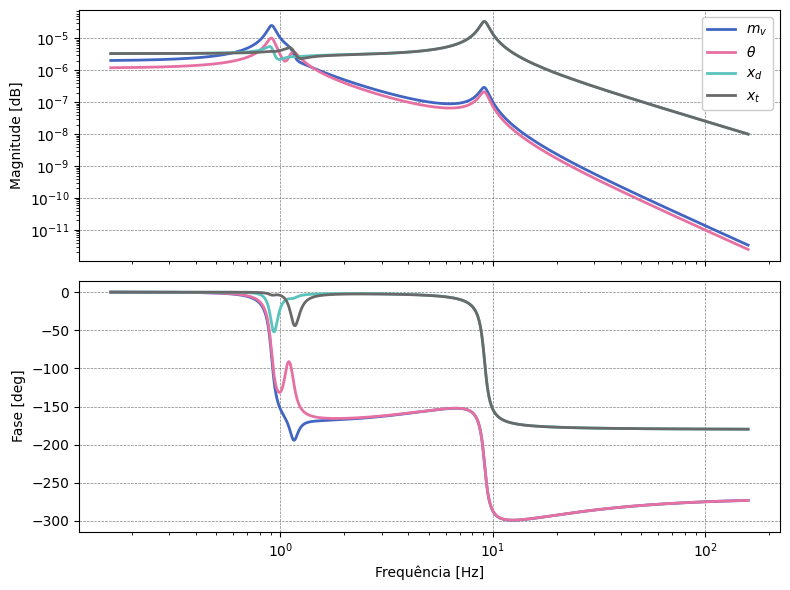

In [10]:
G1 = tf[0,2]
G2 = tf[1,2]
G3 = tf[2,2]
G4 = tf[3,2]

G5 = tf[0,3]
G6 = tf[1,3]
G7 = tf[2,3]
G8 = tf[3,3]

G = [G1,G2,G3,G8]

fig, axs = plt.subplots(2, figsize=(8, 6), sharex=True)

axs[0].clear()
axs[1].clear()

axs[0].semilogx()
axs[0].semilogy()

for i in range(len(G)):
    GI = G[i]

    mag, phase, omega = ct.bode(GI, plot=False)

    axs[0].plot(omega/(2*np.pi), mag, linewidth=2)
    axs[1].plot(omega/(2*np.pi), np.rad2deg(phase), linewidth=2)

axs[0].legend([r'$m_v$', r'$\theta$', r'$x_d$', r'$x_t$'])

axs[0].set_ylabel(r'Magnitude [dB]')
axs[1].set_ylabel(r'Fase [deg]')
axs[1].set_xlabel(r'Frequência [Hz]')

fig.tight_layout()
plt.savefig('FRH.eps')

In [11]:
sampling_period = 1e-2
samples = 1000*6
duration = samples*sampling_period

t = np.arange(0, samples*sampling_period, sampling_period)

U = np.zeros((N, t.shape[0]))

# # 
# put a swep sine in the first wheel

# Define the parameters of the sweep sine function
start_freq = 1.  # starting frequency of the sweep in Hz
stop_freq  = 60.0  # ending frequency of the sweep in Hz

# Generate the sweep sine signal
w = chirp(t, f0=start_freq, f1=stop_freq, t1=duration, method='quadratic')*2*np.pi  # sweep sine waveform

U[2, :] = np.cos(w)*k_sd
U[3, :] = np.sin(w)*k_st

X0 = np.array([0, 0, 0, 0, 0, 0, 0, 0])

_, y = ct.forced_response(sys, t, U, X0=X0)

ys.append(y)

fig, ax = plt.subplots(N, 1, figsize=(8, 8))

for i in range(N):
    ax[i].plot(t, y[i, :], label=f'$x_{i+1}(t)$')
    ax[i].set_ylabel(f'$x_{i+1}(t)$')
    ax[i].legend()

plt.xlabel('Tempo [s]')
plt.savefig('half_car_olc.png', dpi=300, bbox_inches='tight')


NameError: name 'ys' is not defined

In [ ]:
def fft(signal, sampling_time):
    fft = np.fft.fft(signal)
    N = signal.shape[0]

    f = np.fft.fftfreq(len(signal), sampling_time)

    K = N // 2

    freqs = f[:K]*2*np.pi
    amplitudes = np.abs(fft)[:K] * (1 / N)

    phase = np.rad2deg(np.angle(fft)[:K])

    return freqs, amplitudes, phase


ffts   = [fft(y[i, :], sampling_period) for i in range(N)]

maximum_amp = np.max([
    np.max(ffts[i][1]) for i in range(N)
])

maximum_freq = np.max(
    [ffts[i][0][np.argmax(ffts[i][1])] for i in range(N)]
)

plt.figure()
plt.semilogy()

for i in range(N):

    plt.plot(
        ffts[i][0]/(2*np.pi),
        ffts[i][1],
        label=f'$x_{i+1}(t)$'
    )

plt.xlim(.0, 50)
plt.xlabel(r'$\omega [H_z]$')
plt.ylabel('mag(w) [dB]')
# plt.xticks(range(N, 0, -1), np.round((freq), 3))
plt.xticks(range(0, 50, 5))
plt.legend()

plt.savefig('hcfft.png', dpi=300, bbox_inches='tight')